# preliminaries

In [1]:
import os
import sys
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import cmocean.cm as ocm
from scipy import stats
from scipy.signal import detrend
import pandas as pd
import pickle
from scipy import fftpack

proj_dir = '/home/ubuntu/bigStick/antarctic_melting'
data_dir = os.path.join(proj_dir,'data','analysis')
raw_dir = os.path.join(data_dir,'raw')
int_dir = os.path.join(data_dir,'interim')
fig_dir = os.path.join(proj_dir,'reports','tidal_melting','figures')
tab_dir = os.path.join(proj_dir,'reports','tidal_melting','tables')

src_dir = os.path.join(proj_dir,'src')
sys.path.append(src_dir)
tools_dir = os.path.join(proj_dir,'src','tools')
sys.path.append(tools_dir)

%load_ext autoreload
%autoreload 2

from pySSA.mySSA import mySSA
from log_progress import log_progress
from rotate_vector_roms import rotate_vector_roms
from make_masks import make_mask_sector,make_mask_shelf_sector,make_mask_ice_shelves

In [2]:
file_path = os.path.join(raw_dir,'scratch','waom4_hr','ocean_avg_0010.nc')
tides = xr.open_dataset(file_path)#,chunks={'xi_rho':75,'eta_rho':75})
file_path = os.path.join(raw_dir,'scratch','waom4_hr_nt','ocean_avg_0010.nc')
no_tides = xr.open_dataset(file_path)#,chunks={'xi_rho':75,'eta_rho':75})
grid_path = os.path.join(int_dir,'grd4_dV.nc')
grd = xr.open_dataset(grid_path)

mask_sector = make_mask_sector(grd)
mask_shelf = make_mask_shelf_sector(grd,mask_sector,1500) 
mask_shelf['Total Antarctica'][1050:1140,95:113] = True
mask_shelf['Total Antarctica'][:,1500:] = False

grd.mask_rho[570:610,1030:1140] = False

# functions for fft and plotting

In [3]:
plt.rcParams['axes.facecolor']='white'
from mpl_toolkits.axes_grid.inset_locator import inset_axes
import string
    
def plot_inset(ax,eta,xi,dist):

    ax.contourf(grd.mask_rho.values,colors=(('0.6','0.6','0.6')))
    (grd.h+grd.zice).where(grd.mask_rho).plot(ax=ax,cmap=ocm.deep,add_colorbar=False)
    ax.contour(-grd.zice.where(grd.mask_rho).values, levels=['0.01'], colors=('black'))
    ax.contour(grd.mask_rho.values, levels=['0.01'], colors=('black')) 
    ax.set_aspect('equal')
    ax.axis('off')

    mask = (grd.eta_rho>eta-dist) & (grd.eta_rho<eta+dist) & (grd.xi_rho>xi-dist) & (grd.xi_rho<xi+dist)
   
    ax.plot(xi,eta,'rx',ms=14)
    xlim = (grd.xi_rho.where(mask).min(),grd.xi_rho.where(mask).max())
    ylim = (grd.eta_rho.where(mask).min(),grd.eta_rho.where(mask).max())
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    
    return ax

def ax_fft(ax,ts):
    sig_fft = fftpack.fft(ts)
    power = np.abs(sig_fft)**2
    sample_freq = fftpack.fftfreq(ts.size, d=1)
    ax.plot(1/sample_freq, power)
    return ax

def get_axes(ax1,ax2,ts,axtitle,ylabel,legend=False):
    
    ts['ocean_time'] = range(np.size(ts))
    #ts = ts - ts.mean('ocean_time')
    ts[:] = detrend(ts)
    #ts = ts/max(ts.max(),ts.min())
    
    tsLP = ts.rolling(ocean_time=25,center=True).mean().dropna('ocean_time')
    #tsHP = ts - tsLP
    #tsHP = ts
    
    ts.plot(ax=ax1,label='1 hour mean')
    tsLP.plot(ax=ax1, label='25 hour mean')
    ax1.title.set_text(axtitle)
    ax1.set_xlabel('hours')
    ax1.set_ylabel(ylabel)
    if legend:
        ax1.legend()
    
    ax2 = ax_fft(ax2,ts)
    ax2 = ax_fft(ax2,tsLP)

    ax2.set_yscale('log')
    ax2.set_xscale('log')
    ax2.set_xlabel('Period [h]')
    ax2.set_ylabel('power')
    
    return ax1,ax2

def plot_ffts(da,daNT,coords,loc,prop,ylabel):
    
    eta,xi,dist = coords
    
    fig,axes = plt.subplots(2,2,figsize=(10, 8))
    ax1, ax2, ax3, ax4 = axes.flatten()
    ax1,ax2 = get_axes(ax1,ax2,da[:,eta,xi],'With Tides',ylabel,legend=True)
    ax3,ax4 = get_axes(ax3,ax4,daNT[:,eta,xi],'Without Tides',ylabel)
    #ax1.set_ylabel(ylabel)
    
    axi = inset_axes(ax4,height="40%",width="40%", loc=4)
    axi = plot_inset(axi,eta,xi,dist)
    
    n=0
    for ax in axes.flatten():  
        ax.text(-0.1, -0.1, "("+string.ascii_lowercase[n]+")", transform=ax.transAxes, 
                size=12)
        n+=1  
    
    if prop == 'Tstar':
        title = 'T$^*$'
    else:
        title = 'u$^*$'
    fig.suptitle(f'{title} at {loc}',size=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    out_path = os.path.join(fig_dir,'spectrum_'+prop+loc+'.png')
    fig.savefig(out_path,format='png',dpi=300,bbox_inches = "tight")
    plt.show()

/home/ubuntu/bigStick/anaconda3/envs/xesmf_env/lib/python3.6/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.
  


# locations on the map

In [4]:
locs = {'Pine Island Ice Shelf front':(592,348,50),
        'Pine Island Ice Shelf grounding line':(607,354,50),
        'Pine Island Ice Shelf trunk':(601,350,50),
        'Ronne North-West':(867,419,200),
        'Ronne North-East':(886,481,200),
        'North of Henry I. R.':(823,499,200),
        'Evans I.S. pocket':(758,389,200),
        'Evans I.S. western outflow':(769,396,200)}

# timeseries and power spectra of the tidal and non-tidal run

## Tstar

/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in true_divide
/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


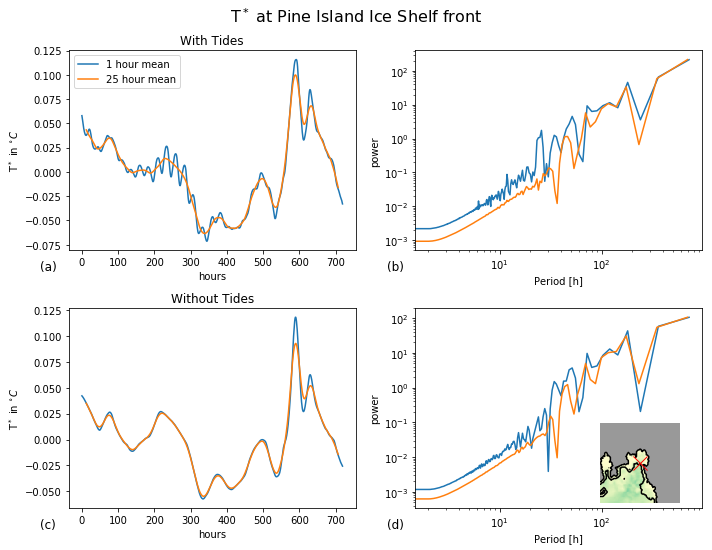

/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in true_divide
/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


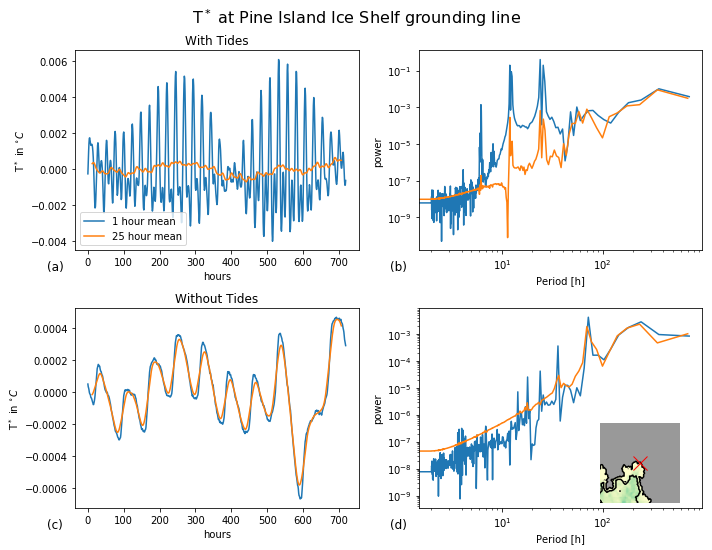

/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in true_divide
/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


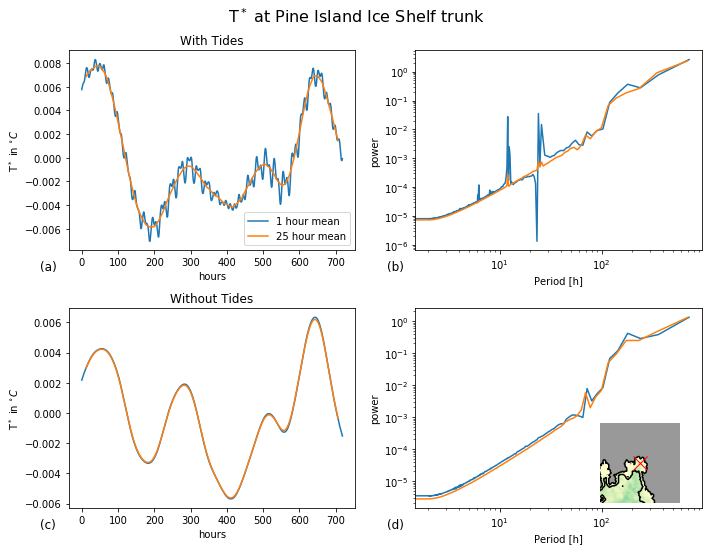

/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in true_divide
/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


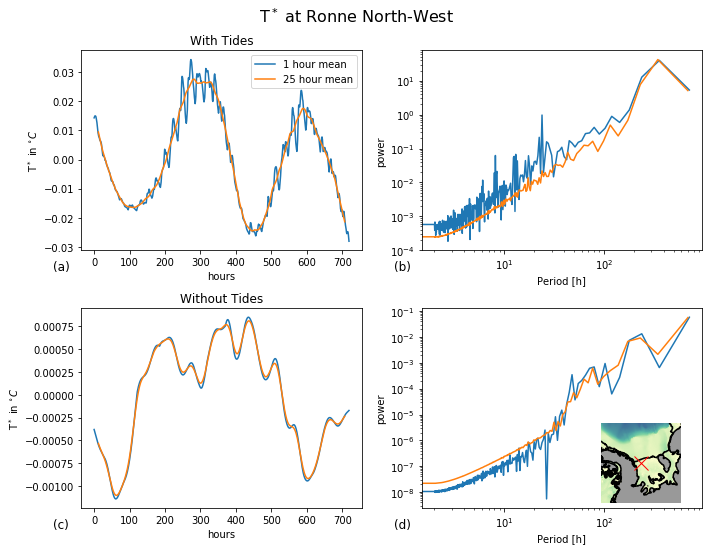

/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in true_divide
/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


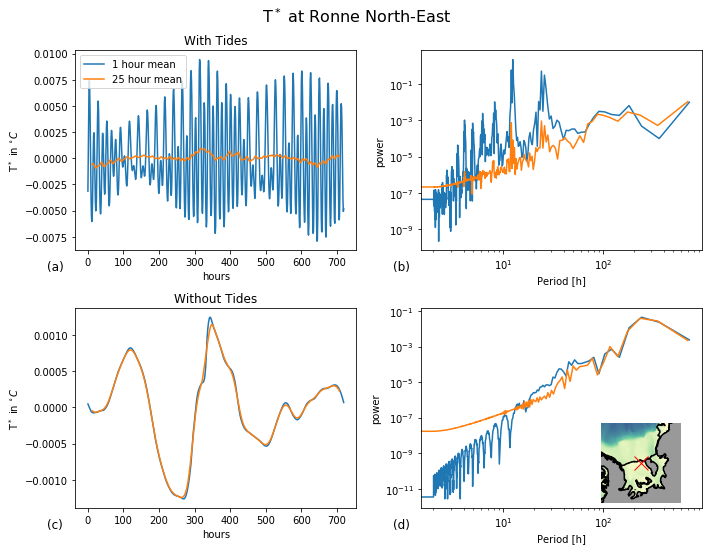

/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in true_divide
/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


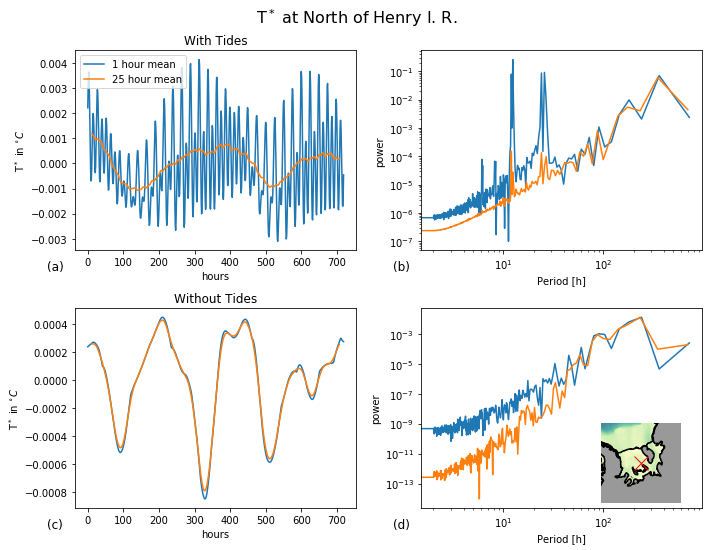

/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in true_divide
/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


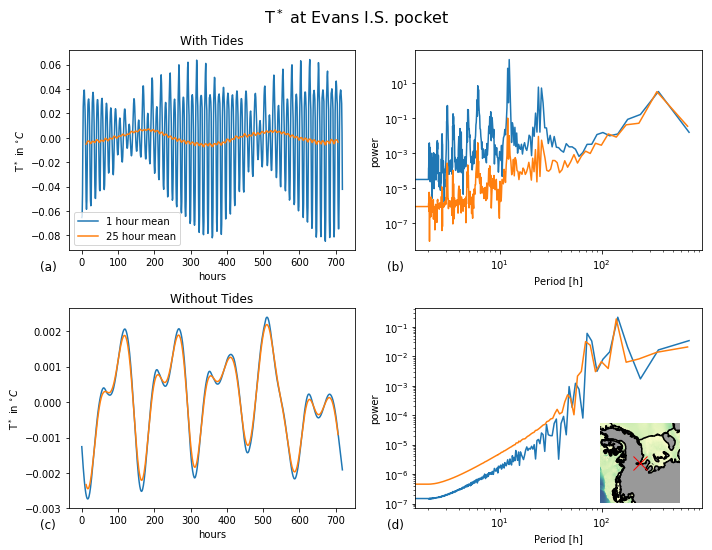

/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in true_divide
/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


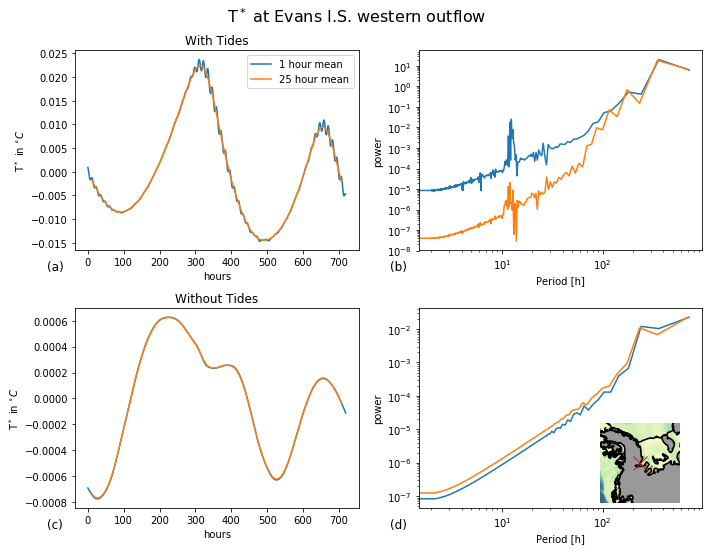

In [28]:
%matplotlib inline
for key,val in locs.items():
    plot_ffts(tides.Tstar,no_tides.Tstar,val,key,'Tstar','T$^*$ in $^{\circ}C$')

## ustar

/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in true_divide
/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


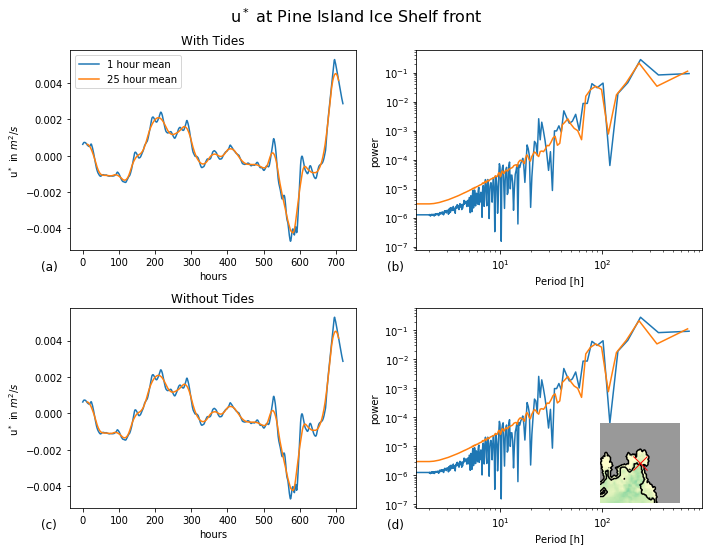

/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in true_divide
/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


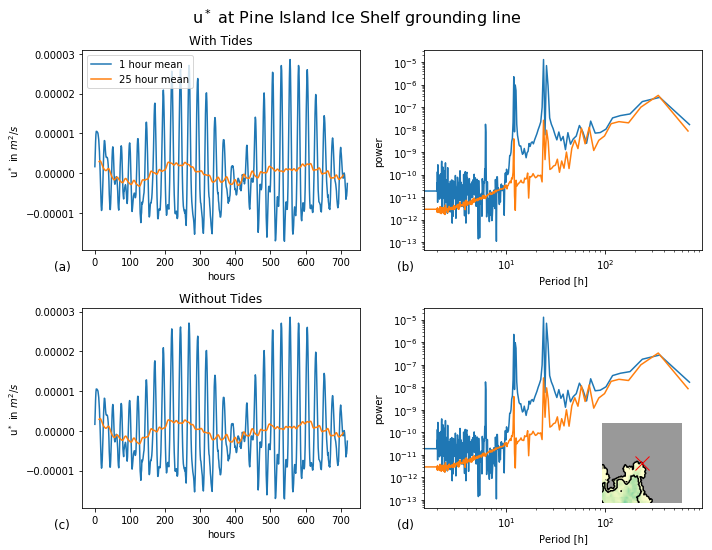

/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in true_divide
/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


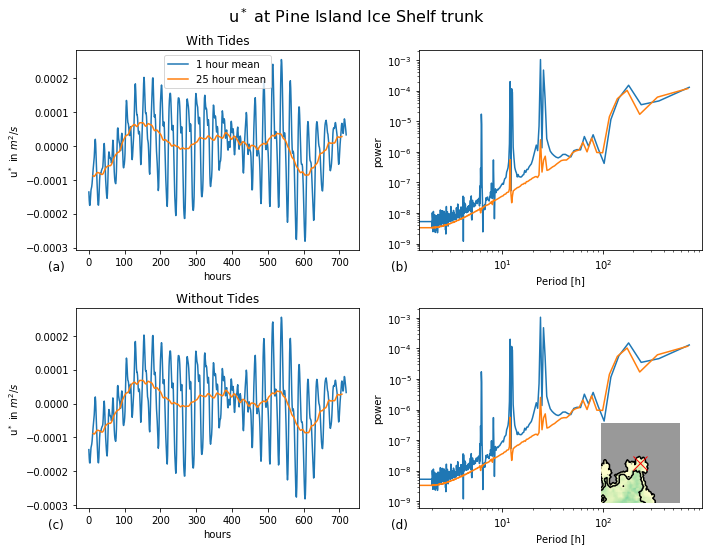

/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in true_divide
/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


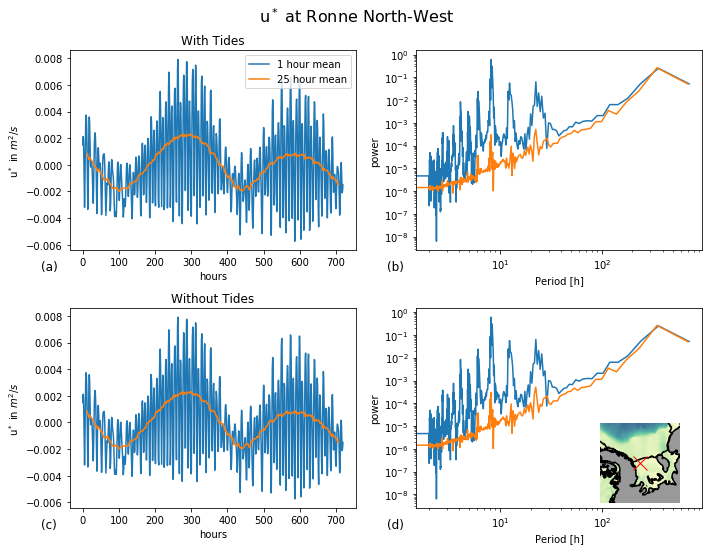

/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in true_divide
/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


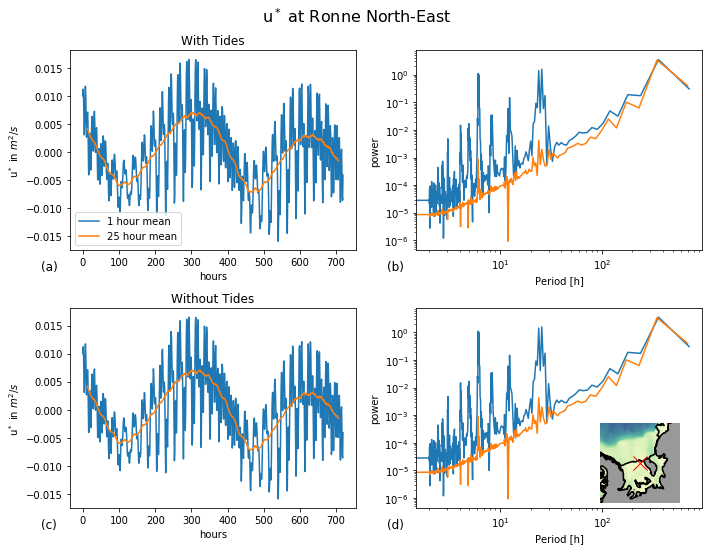

/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in true_divide
/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


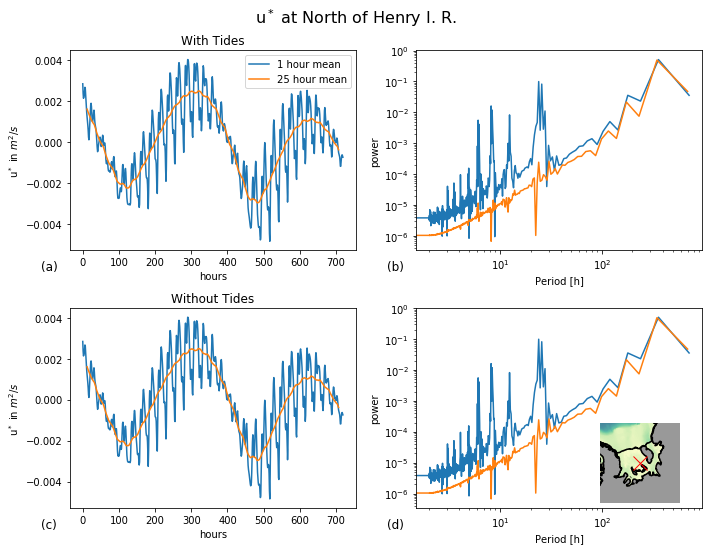

/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in true_divide
/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


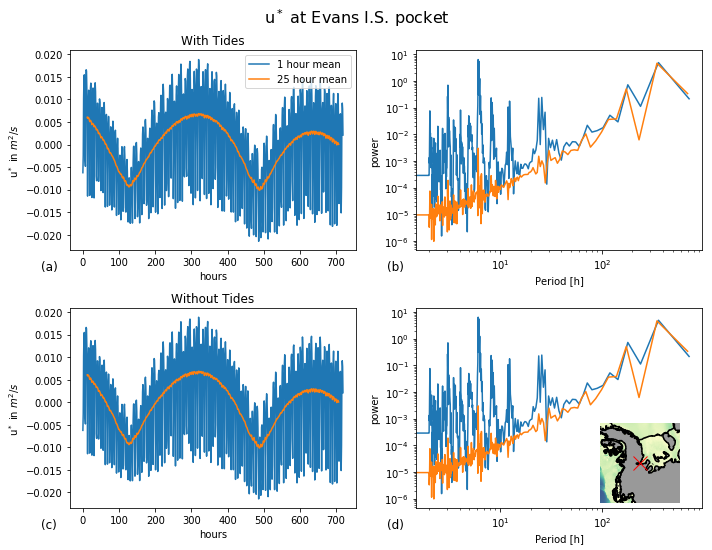

/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in true_divide
/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


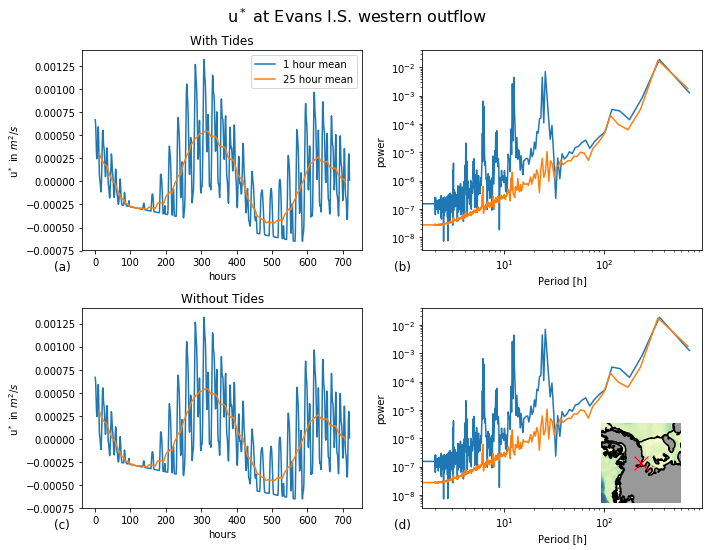

In [13]:
for key,val in locs.items():
    plot_ffts(tides.ustar,tides.ustar,val,key,'ustar','u$^*$ in $m^2/s$')

# u_tide from ubar and vbar

In [172]:
sel = {'xi_rho' : slice(350,650),'eta_rho' : slice(700,1100),
           'xi_u' : slice(350,649),'eta_u' : slice(700,1100),
           'xi_v' : slice(350,650),'eta_v' : slice(700,1099)}
FRIS = tides.isel(sel)
rho_sel = {'xi_rho' : slice(350,650),'eta_rho' : slice(700,1100)}
FRIS_mask = ((grd.mask_rho==1) & (mask_shelf['Total Antarctica']==1)).isel(rho_sel)

In [204]:
sel = {'xi_rho' : slice(350,650),'eta_rho' : slice(700,1100),
           'xi_u' : slice(350,649),'eta_u' : slice(700,1100),
           'xi_v' : slice(350,650),'eta_v' : slice(700,1099)}
FRIS_nt = no_tides.isel(sel)
rho_sel = {'xi_rho' : slice(350,650),'eta_rho' : slice(700,1100)}
FRIS_mask = ((grd.mask_rho==1) & (mask_shelf['Total Antarctica']==1)).isel(rho_sel)

In [132]:
sel = {'xi_rho' : slice(400,450),'eta_rho' : slice(850,900),
           'xi_u' : slice(400,449),'eta_u' : slice(850,900),
           'xi_v' : slice(400,450),'eta_v' : slice(850,899)}
FRIS = tides.isel(sel)
rho_sel = {'xi_rho' : slice(400,450),'eta_rho' : slice(850,900)}
FRIS_mask = ((grd.mask_rho==1) & (mask_shelf['Total Antarctica']==1)).isel(rho_sel)

In [4]:
def get_uv_rho(u,v,mask):
    u_rho = np.zeros((u.ocean_time.size,mask.eta_rho.size,mask.xi_rho.size))
    v_rho = np.zeros_like(u_rho)
    for i in log_progress(range(u.ocean_time.size)):
        u_rho[i],v_rho[i] = rotate_vector_roms(u[i,:,:].values,v[i,:,:].values,np.zeros_like(mask))
    u_rho = xr.DataArray(u_rho,dims=('ocean_time','eta_rho','xi_rho')).where(mask)
    v_rho = xr.DataArray(v_rho,dims=('ocean_time','eta_rho','xi_rho')).where(mask)
    return u_rho,v_rho

def get_u_tide_map(u_rho,v_rho,mask_rho):
    out = np.empty_like(u_rho[0])
    out[:]=np.nan
                        
    for j in log_progress(range(np.size(out,0)),name='eta'):
        if mask_rho[j,:].any()==True:        
            for i in range(np.size(out,1)):           
                if (mask_rho[j,i]==True):
                    if (np.isnan(u_rho[:,j,i]).any()==False):
                        out[j,i] = get_u_tide(u_rho[:,j,i],v_rho[:,j,i]).values
                    
    return xr.DataArray(out,dims=('eta_rho','xi_rho')).where(mask_rho)

def get_u_tide(u,v):
    uHP = get_HP(u)
    vHP = get_HP(v)
    uv_tide = np.sqrt(np.mean(uHP**2+vHP**2))
    return uv_tide

def get_HP(ts):
    ts['ocean_time'] = range(np.size(ts))
    ts[:] = detrend(ts) 
    tsLP = ts.rolling(ocean_time=25,center=True).mean().dropna('ocean_time')
    
    return ts-tsLP

In [5]:
file_path = os.path.join(raw_dir,'scratch','waom4_hr','ocean_his_winter_0020.nc')
tides = xr.open_dataset(file_path)
mask = (grd.mask_rho==1) & (mask_shelf['Total Antarctica']==1)
u_rho,v_rho = get_uv_rho(tides.ubar,tides.vbar,mask)

In [6]:
u_tide_map = get_u_tide_map(u_rho,v_rho,mask)

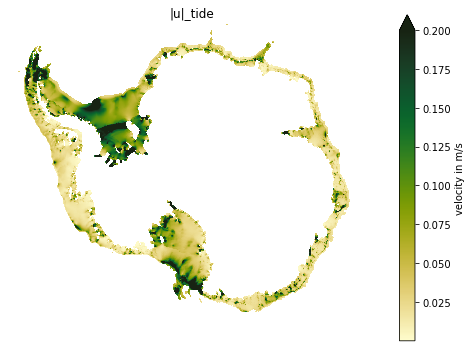

In [7]:
%matplotlib inline
#u_tide_map=xr.open_dataarray(os.path.join(int_dir,'u_tide_HP.nc'))
fig,ax = plt.subplots(figsize=(8.27,6))
u_tide_map.plot(ax=ax,cmap=ocm.speed,vmax=0.2,cbar_kwargs={'label':'velocity in m/s'})
ax.axis('off')
ax.set_title ('|u|_tide')
ax.set_aspect('equal')
plt.show()

In [8]:
u_tide_map.to_netcdf(os.path.join(int_dir,'u_tide_HP_winter.nc'))
#u_tide_map.to_netcdf(os.path.join(int_dir,'u_tide_HP.nc'))

In [10]:
u_tide_map = xr.open_dataarray(os.path.join(int_dir,'u_tide_HP_winter.nc'))
u_tide_map_old = xr.open_dataarray(os.path.join(int_dir,'u_tide_HP.nc'))

In [204]:
u_tide_map

<xarray.DataArray (eta_rho: 1325, xi_rho: 1575)>
[2086875 values with dtype=float64]
Dimensions without coordinates: eta_rho, xi_rho

In [207]:
u_tide_map_old=u_tide_map_old.rename({'xi_rho':'eta_rho','eta_rho':'xi_rho'})

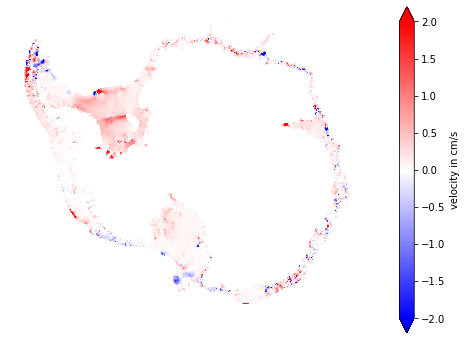

In [21]:
fig,ax = plt.subplots(figsize=(8.27,6))
((u_tide_map-u_tide_map_old)*100).plot(ax=ax,cmap='bwr',vmin=-2,vmax=2,cbar_kwargs={'label':'velocity in cm/s'})
ax.axis('off')
#ax.set_title ('|u|_tide - |u|_tide_old')
ax.set_aspect('equal')
plt.show()

# Tstar HP and LP 

In [19]:
def get_uv_rho(u,v,mask):
    u_rho = np.zeros((u.ocean_time.size,mask.eta_rho.size,mask.xi_rho.size))
    v_rho = np.zeros_like(u_rho)
    for i in log_progress(range(u.ocean_time.size)):
        u_rho[i],v_rho[i] = rotate_vector_roms(u[i,:,:].values,v[i,:,:].values,np.zeros_like(mask))
    u_rho = xr.DataArray(u_rho,dims=('ocean_time','eta_rho','xi_rho')).where(mask)
    v_rho = xr.DataArray(v_rho,dims=('ocean_time','eta_rho','xi_rho')).where(mask)
    return u_rho,v_rho

def get_HPLP(ts):
    #LP = ts.chunk(chunks={'xi_rho':5,'eta_rho':5}).rolling(ocean_time=25,center=True).mean().dropna('ocean_time','all').load()
    LP = ts.rolling(ocean_time=25,center=True).mean().dropna('ocean_time','all')
    HP = ts-LP                    
    return HP,LP

def loop_sqrt(u,v):
    ustar = u.copy()
    for i in log_progress(range(u.ocean_time.size)):
        ustar[i]=np.sqrt(np.sqrt(u[i]**2+v[i]**2))
    return ustar

def get_str_HPLP(sustr_rho,svstr_rho):
    sustrHP,sustrLP = get_HPLP(sustr_rho)
    svstrHP,svstrLP = get_HPLP(svstr_rho)
    return sustrHP,svstrHP,sustrLP,svstrLP

def add_filtered_star(ds,mask):
    print('getting sustr_rho, svstr_rho')
    sustr_rho,svstr_rho = get_uv_rho(ds.sustr,ds.svstr,mask)
    sustr_rho.to_netcdf(os.path.join(int_dir,'sustr_rho_nt.nc'))
    svstr_rho.to_netcdf(os.path.join(int_dir,'svstr_rho_nt.nc'))
    #sustr_rho = xr.open_dataarray(os.path.join(int_dir,'sustr_rho.nc'))
    #svstr_rho = xr.open_dataarray(os.path.join(int_dir,'svstr_rho.nc'))
    sustr_rho['ocean_time']=ds.svstr.ocean_time
    svstr_rho['ocean_time']=ds.svstr.ocean_time
    print('getting FP str')
    sustrHP,svstrHP,sustrLP,svstrLP = get_str_HPLP(sustr_rho,svstr_rho)
    sustr_rho=None
    svstr_rho=None
    print('getting ustar_HP')
    ds['ustarHP'] = loop_sqrt(sustrHP,svstrHP)
    sustrHP = None
    svstrHP = None
    print('getting ustar_LP')
    ds['ustarLP'] = loop_sqrt(sustrLP,svstrLP)
    sustrLP = None
    svstrLP = None
    print('processing Tstar')
    ds['TstarHP'],ds['TstarLP'] = get_HPLP(ds.Tstar)
    return ds

In [4]:
mask = (grd.mask_rho==1) & (grd.zice<0)
tides = add_filtered_star(tides,mask)
tides[['ustarHP','ustarLP']].to_netcdf(os.path.join(int_dir,'filtered_star.nc'))

processing Tstar
getting sustr_rho, svstr_rho
getting FP str
getting ustar_HP


getting ustar_LP


In [5]:
tides['TstarHP'],tides['TstarLP'] = get_HPLP(tides.Tstar)
tides[['TstarLP','TstarHP','ustarHP','ustarLP']].to_netcdf(os.path.join(int_dir,'filtered_star.nc'))

In [4]:
file_path = os.path.join(raw_dir,'scratch','waom4_hr_nt','ocean_avg_0010.nc')
no_tides = xr.open_dataset(file_path)
mask = (grd.mask_rho==1) & (grd.zice<0)
no_tides = add_filtered_star(no_tides,mask)
no_tides[['TstarLP','TstarHP','ustarHP','ustarLP']].to_netcdf(os.path.join(int_dir,'filtered_star_nt.nc'))

getting sustr_rho, svstr_rho


getting FP str
getting ustar_HP


getting ustar_LP


processing Tstar


In [5]:
print("done")

done


In [4]:
from dask.distributed import Client
C = Client()
chunks = {'ocean_time':150,'xi_rho':25,'eta_rho':25}

In [5]:
ds = tides.copy()


In [5]:
sustr_rho,svstr_rho = get_uv_rho(ds.sustr,ds.svstr,mask)
sustr_rho.to_netcdf(os.path.join(int_dir,'sustr_rho.nc'))
svstr_rho.to_netcdf(os.path.join(int_dir,'svstr_rho.nc'))

NameError: name 'get_uv_rho' is not defined

In [4]:
sustr_rho = xr.open_dataarray(os.path.join(int_dir,'sustr_rho.nc'))
svstr_rho = xr.open_dataarray(os.path.join(int_dir,'svstr_rho.nc'))
sustr_rho['ocean_time']=tides.svstr.ocean_time
svstr_rho['ocean_time']=tides.svstr.ocean_time

In [9]:
sustrHP,sustrLP = get_HPLP(sustr_rho)

In [10]:
svstrHP,svstrLP = get_HPLP(svstr_rho)

In [12]:
sustrHP.to_netcdf(os.path.join(int_dir,'sustrHP.nc'))
svstrHP.to_netcdf(os.path.join(int_dir,'svstrHP.nc'))

In [15]:
svstr_rho=None
sustr_rho=None
sustrLP = None
svstrLP = None

In [4]:
sustrHP=xr.open_dataarray(os.path.join(int_dir,'sustrHP.nc'))
svstrHP=xr.open_dataarray(os.path.join(int_dir,'svstrHP.nc'))
print('create arrays')
ustar_HP = svstrHP.copy()
#ustar_LP = svstrHP.copy()
print('loop')
for i in log_progress(range(svstrHP.ocean_time.size)):
    ustar_HP[i]=np.sqrt(np.sqrt(sustrHP[i]**2+svstrHP[i]**2))
    #ustar_LP[i]=np.sqrt(np.sqrt(sustrLP[i]**2+svstrLP[i]**2))

create arrays
loop


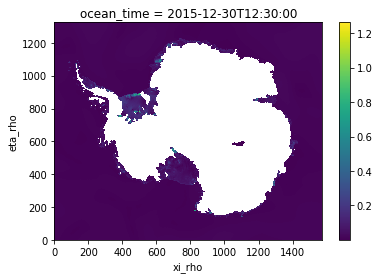

In [5]:
ustar_HP[0].plot()

In [9]:
chunks = {'ocean_time':150,'xi_rho':25,'eta_rho':25}
ustar_HP = np.sqrt(np.sqrt(sustrHP.chunk(chunks=chunks)**2+svstrHP.chunk(chunks=chunks)**2))

In [11]:
ustar_HP.load()

distributed.protocol.core - CRITICAL - Failed to Serialize
Traceback (most recent call last):
  File "/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/distributed/protocol/core.py", line 44, in dumps
    for key, value in data.items()
  File "/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/distributed/protocol/core.py", line 45, in <dictcomp>
    if type(value) is Serialize}
  File "/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/distributed/protocol/serialize.py", line 215, in serialize
    raise TypeError(msg)
TypeError: Could not serialize object of type ImplicitToExplicitIndexingAdapter
distributed.comm.utils - ERROR - Could not serialize object of type ImplicitToExplicitIndexingAdapter
Traceback (most recent call last):
  File "/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/distributed/comm/utils.py", line 40, in _to_frames
    on_error=on_err

KeyboardInterrupt: 

In [ ]:
ustar_HP[0].plot()

In [9]:
mask = (grd.mask_rho==1) & (grd.zice<0)
tides['ustarHP'],tides['ustarLP'] = get_ustar_HPLP(sustr_rho.where(mask),svstr_rho.where(mask))

distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://127.0.0.1:58294 remote=tcp://127.0.0.1:40786>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://127.0.0.1:58297 remote=tcp://127.0.0.1:40786>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://127.0.0.1:58298 remote=tcp://127.0.0.1:40786>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://127.0.0.1:58299 remote=tcp://127.0.0.1:40786>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://127.0.0.1:58300 remote=tcp://127.0.0.1:40786>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://127.0.0.1:58301 remote=tcp://127.0.0.1:40786>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://127.0.0.1:58302 remote=tcp://127.0.0.1:40786>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://127.0.0.1:58303 remote=tcp://127.0.0.1:40786>
distributed.comm

KeyboardInterrupt: 

distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker exceeded 95% memory budget.  Restarting
distributed.nanny - WARNING - Worker process 22087 was killed by unknown signal
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker


In [ ]:
tides.ustarHP[0].plot()

In [ ]:
mask = (grd.mask_rho==1) & (grd.zice<0)
no_tides = add_filterted_star(no_tides,mask)
no_tides[['TstarLP','TstarHP','ustarHP','ustarLP']].to_netcdf(os.path.join(int_dir,'filtered_star.nc'))

distributed.protocol.core - CRITICAL - Failed to Serialize
Traceback (most recent call last):
  File "/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/distributed/protocol/core.py", line 44, in dumps
    for key, value in data.items()
  File "/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/distributed/protocol/core.py", line 45, in <dictcomp>
    if type(value) is Serialize}
  File "/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/distributed/protocol/serialize.py", line 215, in serialize
    raise TypeError(msg)
TypeError: Could not serialize object of type Variable
distributed.comm.utils - ERROR - Could not serialize object of type Variable
Traceback (most recent call last):
  File "/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/distributed/comm/utils.py", line 40, in _to_frames
    on_error=on_error))
  File "/home/ubuntu/bigStick/anaconda3/envs/

In [ ]:
tides = add_filterted_star(tides,mask)
tides[['TstarLP','TstarHP','ustarHP','ustarLP']].to_netcdf(os.path.join(int_dir,'filtered_star.nc'))

# Plotting

In [14]:
def make_text(ax,text):
    ax.text(0.0, 1.1, text,transform=ax.transAxes,size=14)
    return ax

In [22]:
def plot_m(ax,da,dm,text,vmin=None,vmax=None):
    if vmin==None:
        da.plot(ax=ax,vmin=-da.std()*2,vmax=da.std()*2,cmap=ocm.balance,cbar_kwargs={'label': 'u*T* in m/s*degC'})
    else:
        da.plot(ax=ax,vmin=vmin,vmax=vmax,cmap=ocm.balance,cbar_kwargs={'label': 'u*T* in m/s*degC'})
    ax = make_text(ax,text)
    ax = show_perc(ax,da,dm,grd)
    return ax

In [16]:
def show_perc(ax,da,dm,grd):
    dA = (grd.pn*grd.pm)**-1
    tot = (da*dA).sum()/(dm*dA).sum()*100
    pos = (da.where(da>0)*dA).sum()/(dm.where(dm>0)*dA).sum()*100
    neg = (da.where(da<0)*dA).sum()/(dm.where(dm<0)*dA).sum()*100
    
    ax.text(0.0, 1.0, f'Total (pos, neg): {tot.values:.2f}% ({pos.values:.2f}%, {neg.values:.2f}%)',transform=ax.transAxes,size=12)
    
    return ax

## FRIS only

In [59]:
fs = xr.open_dataset(os.path.join(int_dir,'filtered_star.nc'))
fs_nt = xr.open_dataset(os.path.join(int_dir,'filtered_star_nt.nc'))

rho_sel = {'xi_rho' : slice(350,650),'eta_rho' : slice(700,950)}
fris = fs.isel(rho_sel)
frisNt = fs_nt.isel(rho_sel)
mask = ((grd.mask_rho==1) & (mask_shelf['Total Antarctica']==1)).isel(rho_sel)
fris_grd = grd.isel(rho_sel)

from dask.distributed import Client
C = Client()
chunks = {'xi_rho':75,'eta_rho':75}

fris = fris.chunk(chunks)
frisNt = frisNt.chunk(chunks)

distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://127.0.0.1:33125 remote=tcp://127.0.0.1:56531>


OSError: Timed out trying to connect to 'tcp://127.0.0.1:57377' after 3 s: connect() didn't finish in time

distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://127.0.0.1:36235 remote=tcp://127.0.0.1:53223>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://127.0.0.1:33133 remote=tcp://127.0.0.1:56531>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://127.0.0.1:39643 remote=tcp://127.0.0.1:49885>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://127.0.0.1:33137 remote=tcp://127.0.0.1:56531>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://127.0.0.1:39647 remote=tcp://127.0.0.1:49885>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://127.0.0.1:39650 remote=tcp://127.0.0.1:49885>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://127.0.0.1:39638 remote=tcp://127.0.0.1:49885>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://127.0.0.1:33130 remote=tcp://127.0.0.1:56531>
distributed.comm

In [125]:
s2a=3600*24*365.25
m_mean = tides.m.isel(rho_sel).mean('ocean_time').where(mask)*s2a
m_std = tides.m.isel(rho_sel).std('ocean_time').where(mask)*s2a
mstar_mean = ((fris.TstarHP + fris.TstarLP) * (fris.ustarHP + fris.ustarLP)).where(mask).mean('ocean_time').load()
mstar_std = ((fris.TstarHP + fris.TstarLP) * (fris.ustarHP + fris.ustarLP)).where(mask).std('ocean_time').load()

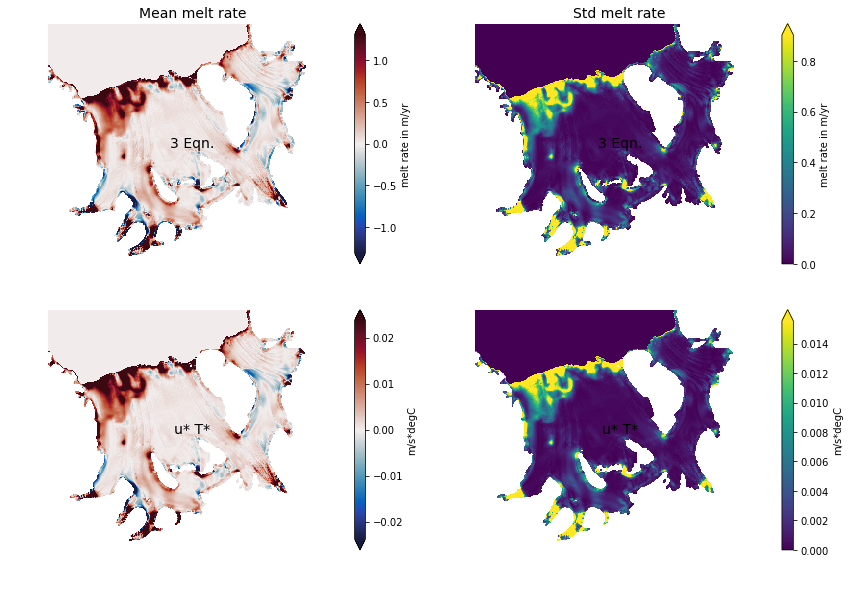

In [127]:
fig,axes = plt.subplots(2,2,figsize=(12,8.27))
ax1,ax2,ax3,ax4 = axes.flatten()
m_mean.plot(ax=ax1,vmin=-m_mean.std()*2,vmax=m_mean.std()*2,
                  cmap=ocm.balance,cbar_kwargs={'label': 'melt rate in m/yr'})
m_std.plot(ax=ax2,vmax=m_std.std()*2,cbar_kwargs={'label': 'melt rate in m/yr'})

mstar_mean.plot(ax=ax3,vmin=-mstar_mean.std()*2,vmax=mstar_mean.std()*2,
                      cmap=ocm.balance,cbar_kwargs={'label': 'm/s*degC'})
mstar_std.plot(ax=ax4,vmax=mstar_std.std()*2,cbar_kwargs={'label': 'm/s*degC'})

ax1.set_title('Mean melt rate',size=14)
ax2.set_title('Std melt rate',size=14)

ax1 = text(ax1,'3 Eqn.')
ax3 = text(ax3,'u* T*')
ax2 = text(ax2,'3 Eqn.')
ax4 = text(ax4,'u* T*')

for ax in axes.flatten():
    ax.set_aspect('equal')
    ax.axis('off')
plt.tight_layout()
plt.show()

In [55]:
mstar_HPHP = (fris.ustarHP*fris.TstarHP).where(mask).mean('ocean_time')
mstar_LPLP = (fris.ustarLP*fris.TstarLP).where(mask).mean('ocean_time')
mstar_HPLP = (fris.ustarHP*fris.TstarLP).where(mask).mean('ocean_time')
mstar_LPHP = (fris.ustarLP*fris.TstarHP).where(mask).mean('ocean_time')

mstar_HPHP_nt = (frisNt.ustarHP*frisNt.TstarHP).where(mask).mean('ocean_time')
mstar_LPLP_nt = (frisNt.ustarLP*frisNt.TstarLP).where(mask).mean('ocean_time')
mstar_HPLP_nt = (frisNt.ustarHP*frisNt.TstarLP).where(mask).mean('ocean_time')
mstar_LPHP_nt = (frisNt.ustarLP*frisNt.TstarHP).where(mask).mean('ocean_time')

dHPHP = (mstar_HPHP - mstar_HPHP_nt).load(); print('ping')
dLPLP = (mstar_LPLP - mstar_LPLP_nt).load(); print('ping')
dHPLP = (mstar_HPLP - mstar_HPLP_nt).load(); print('ping')
dLPHP = (mstar_LPHP - mstar_LPHP_nt).load(); print('ping')
dm = (dHPHP+dLPLP+dHPLP+dLPHP).load()

ping
ping
ping
ping


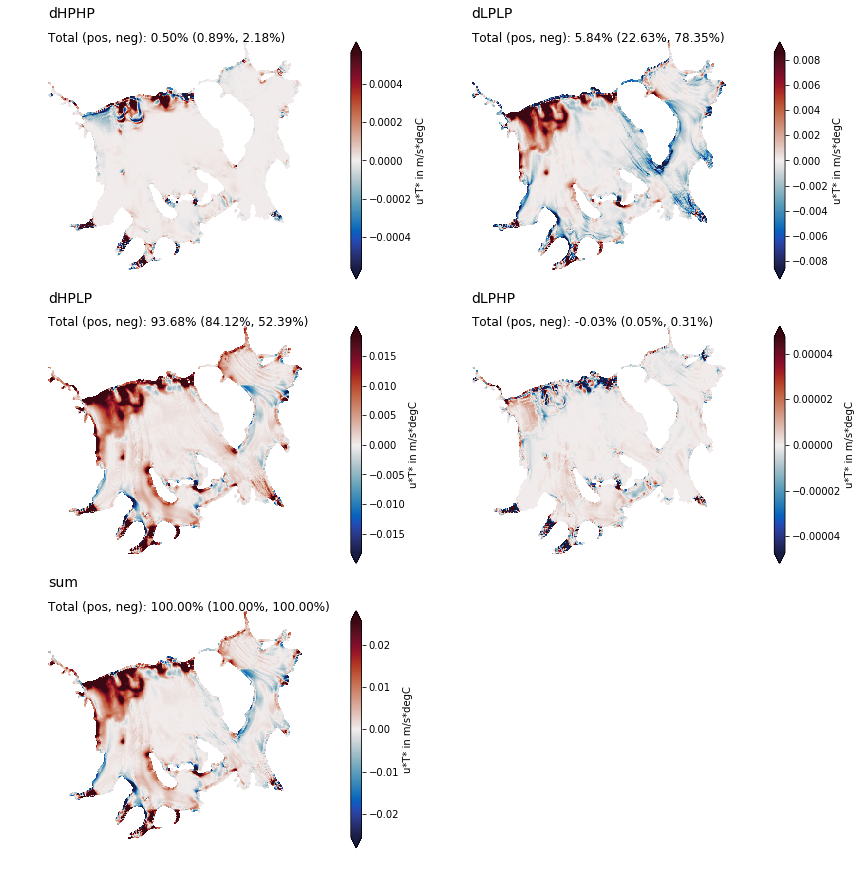

In [81]:
fig,axes = plt.subplots(ncols=2,nrows=3,figsize=(12,12))
ax1,ax2,ax3,ax4,ax5,ax6 = axes.flatten()

ax1 = plot_m(ax1,dHPHP, 'dHPHP')
ax2 = plot_m(ax2,dLPLP, 'dLPLP')
ax3 = plot_m(ax3,dHPLP, 'dHPLP')
ax4 = plot_m(ax4,dLPHP, 'dLPHP')
ax5 = plot_m(ax5,dm, 'sum')

for ax in axes.flatten():
    ax.set_aspect('equal')
    ax.axis('off')
plt.tight_layout()
plt.show()

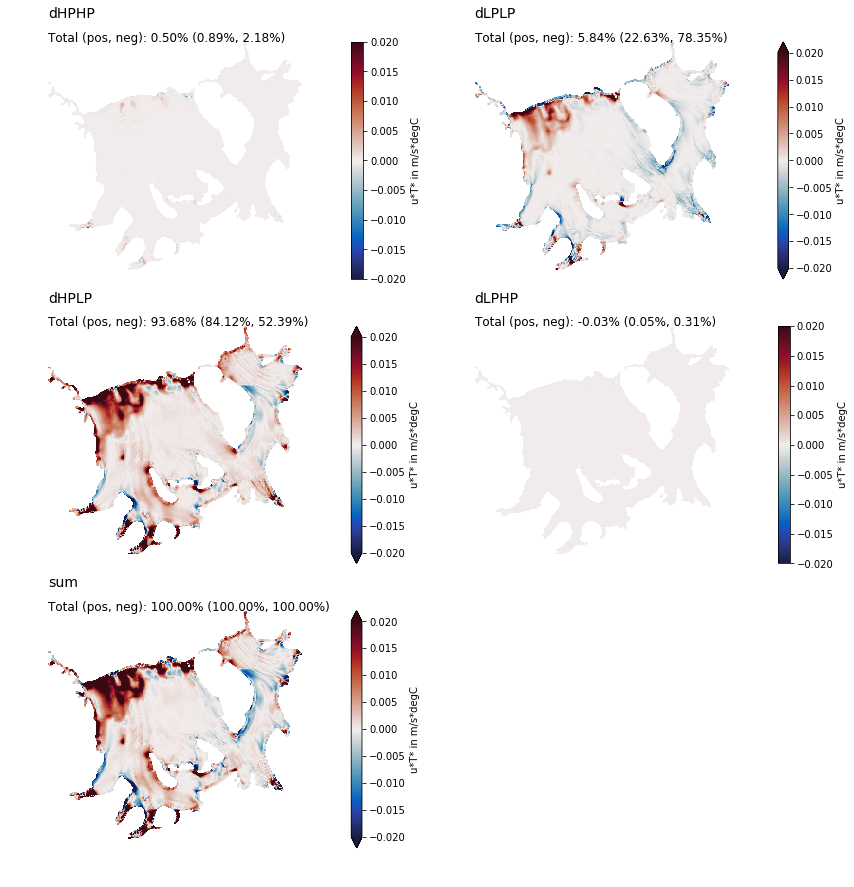

In [82]:
fig,axes = plt.subplots(ncols=2,nrows=3,figsize=(12,12))
ax1,ax2,ax3,ax4,ax5,ax6 = axes.flatten()

ax1 = plot_m(ax1,dHPHP, 'dHPHP',vmin = -0.02,vmax=0.02)
ax2 = plot_m(ax2,dLPLP, 'dLPLP',vmin = -0.02,vmax=0.02)
ax3 = plot_m(ax3,dHPLP, 'dHPLP',vmin = -0.02,vmax=0.02)
ax4 = plot_m(ax4,dLPHP, 'dLPHP',vmin = -0.02,vmax=0.02)
ax5 = plot_m(ax5,dm, 'sum',vmin = -0.02,vmax=0.02)


for ax in axes.flatten():
    ax.set_aspect('equal')
    ax.axis('off')
plt.tight_layout()
plt.show()

### old

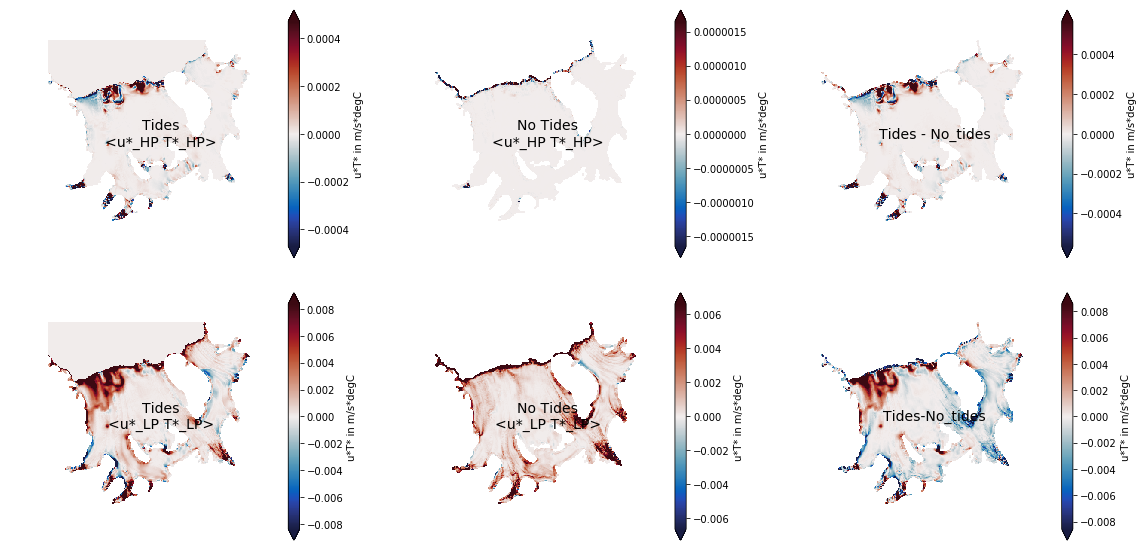

In [134]:
fig,axes = plt.subplots(ncols=3,nrows=2,figsize=(16,8))
ax1,ax2,ax3,ax4,ax5,ax6 = axes.flatten()

ax1 = plot_m(ax1,mstar_HP,'Tides\n<u*_HP T*_HP>')
ax2 = plot_m(ax2,mstar_HP_nt,'No Tides\n<u*_HP T*_HP>')
ax3 = plot_m(ax3,mstar_HP-mstar_HP_nt,'Tides - No_tides')
ax4 = plot_m(ax4,mstar_LP,'Tides\n<u*_LP T*_LP>')
ax5 = plot_m(ax5,mstar_LP_nt,'No Tides\n<u*_LP T*_LP>')
ax6 = plot_m(ax6,mstar_LP-mstar_LP_nt,'Tides-No_tides')

for ax in axes.flatten():
    ax.set_aspect('equal')
    ax.axis('off')
plt.tight_layout()
plt.show()

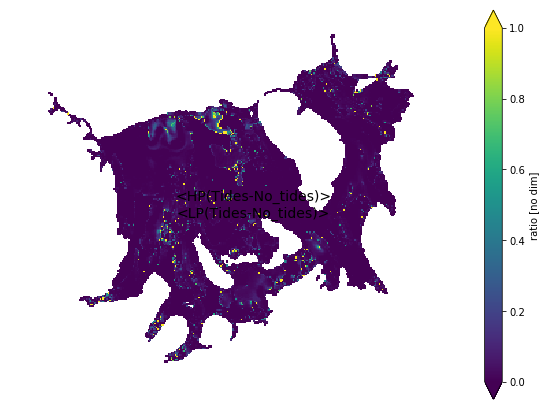

In [135]:
fig,ax = plt.subplots(figsize=(8,6))
((mstar_HP-mstar_HP_nt)/(mstar_LP-mstar_LP_nt)).plot(ax=ax,vmin=0,vmax=1,cmap='viridis',cbar_kwargs={'label': 'ratio [no dim]'})
ax.set_aspect('equal')
ax = make_text(ax,'<HP(Tides-No_tides)>\n<LP(Tides-No_tides)>')
ax.axis('off')
plt.tight_layout()
plt.show()

In [137]:
mstar = zoom(((fris.TstarHP + fris.TstarLP) * (fris.ustarHP + fris.ustarLP)).where(mask)).mean('ocean_time').load()
mstar_u = zoom(((fris.TstarHP + fris.TstarLP) * ( fris.ustarLP)).where(mask)).mean('ocean_time').load()
mstar_T = zoom(((fris.TstarLP) * (fris.ustarHP + fris.ustarLP)).where(mask)).mean('ocean_time').load()

fig,axes = plt.subplots(2,2,figsize=(12,8.27))
ax1,ax2,ax3,ax4 = axes.flatten()

ax1 = plot_m(ax1,mstar,'mstar:\n<(u*_HP+u*_LP)x(T*_HP+T*_LP)>')
ax2 = plot_m(ax2,mstar_u-mstar,'mstar_u*:\n<(u*_LP)x(T*_HP+T*_LP)> - mstar')
ax3 = plot_m(ax3,mstar_T-mstar,'mstar_T*:\n<(u*_HP+u*_LP)x(T*_LP)> - mstar')
(np.abs(mstar_u-mstar)/np.abs(mstar_T-mstar)).plot(ax=ax4,vmin=0,vmax=10,cmap='viridis',cbar_kwargs={'label': 'u*T* in ?'})
ax4 = make_text(ax4,'|mstar_u*|/|mstar_T*|')

for ax in axes.flatten():
    ax.set_aspect('equal')
    ax.axis('off')
plt.tight_layout()
plt.show()

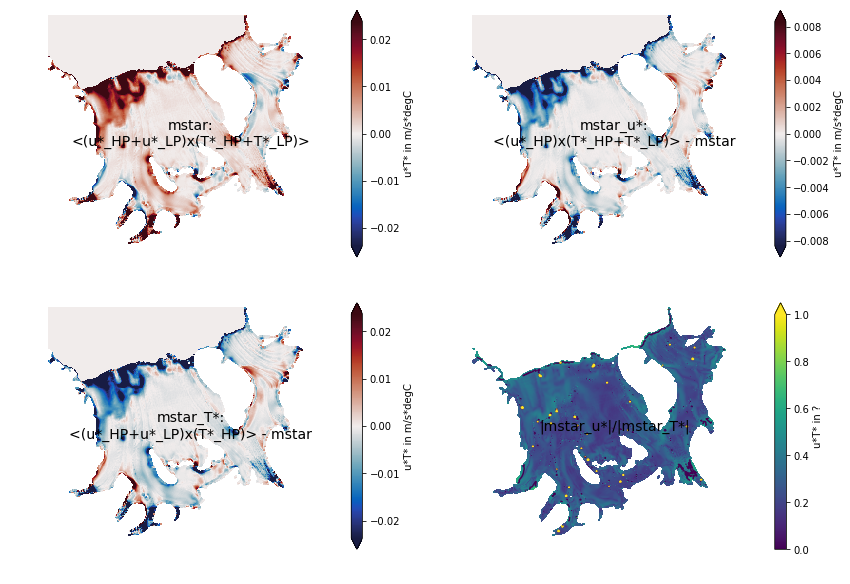

In [142]:
#mstar = ((fris.TstarHP + fris.TstarLP) * (fris.ustarHP + fris.ustarLP)).where(mask).mean('ocean_time').load()
#mstar_u = ((fris.TstarHP + fris.TstarLP) * ( fris.ustarHP)).where(mask).mean('ocean_time').load()
#mstar_T = ((fris.TstarHP) * (fris.ustarHP + fris.ustarLP)).where(mask).mean('ocean_time').load()

fig,axes = plt.subplots(2,2,figsize=(12,8.27))
ax1,ax2,ax3,ax4 = axes.flatten()

ax1 = plot_m(ax1,mstar,'mstar:\n<(u*_HP+u*_LP)x(T*_HP+T*_LP)>')
ax2 = plot_m(ax2,mstar_u-mstar,'mstar_u*:\n<(u*_HP)x(T*_HP+T*_LP)> - mstar')
ax3 = plot_m(ax3,mstar_T-mstar,'mstar_T*:\n<(u*_HP+u*_LP)x(T*_HP)> - mstar')
(np.abs(mstar_u-mstar)/np.abs(mstar_T-mstar)).plot(ax=ax4,vmin=0,vmax=1,cmap='viridis',cbar_kwargs={'label': 'u*T* in ?'})
ax4 = make_text(ax4,'|mstar_u*|/|mstar_T*|')
#(np.abs(mstar_u-mstar)/np.abs(mstar_T-mstar)).plot.contour(ax=ax4,levels=[0.5,0.75])

for ax in axes.flatten():
    ax.set_aspect('equal')
    ax.axis('off')
plt.tight_layout()
plt.show()

In [205]:
FRIS_nt = add_filterted_star(FRIS_nt,FRIS_mask)
FRIS[['TstarLP','TstarHP','ustarHP','ustarLP']].to_netcdf(os.path.join(int_dir,'filtered_star_nt.nc'))

In [ ]:
FRIS = add_filtered_star(FRIS,FRIS_mask)
FRIS[['TstarLP','TstarHP','ustarHP','ustarLP']].to_netcdf(os.path.join(int_dir,'filtered_star.nc'))

In [188]:
mstarHP = (FRIS.ustarHP*FRIS.TstarHP).mean('ocean_time').where(FRIS.ustarHP[0]!=0.0)
mstarLP = (FRIS.ustarLP*FRIS.TstarLP).mean('ocean_time').where(FRIS.ustarHP[0]!=0.0)

In [206]:
mstarHP_nt = (FRIS_nt.ustarHP*FRIS_nt.TstarHP).mean('ocean_time')
mstarLP_nt = (FRIS_nt.ustarLP*FRIS_nt.TstarLP).mean('ocean_time')

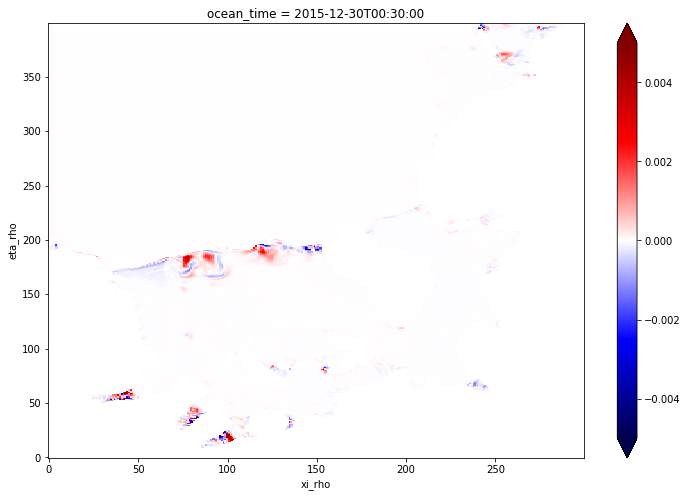

In [219]:
mstarHP.plot(size=8,vmin=-0.005,vmax=0.005,cmap='seismic')

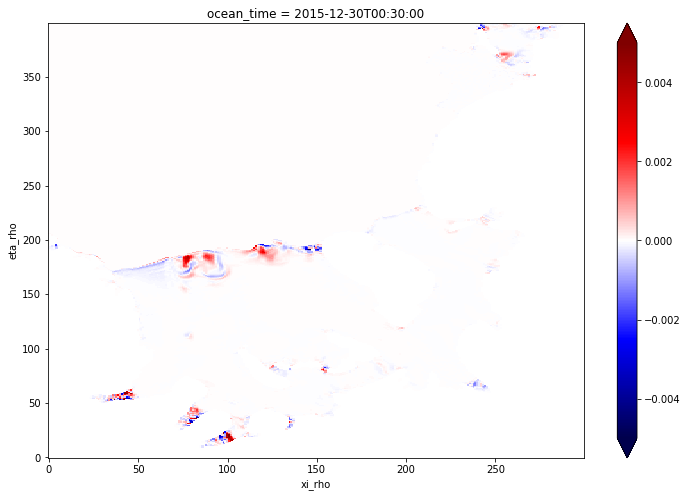

In [220]:
(mstarHP-mstarHP_nt).plot(size=8,vmin=-0.005,vmax=0.005,cmap='seismic')

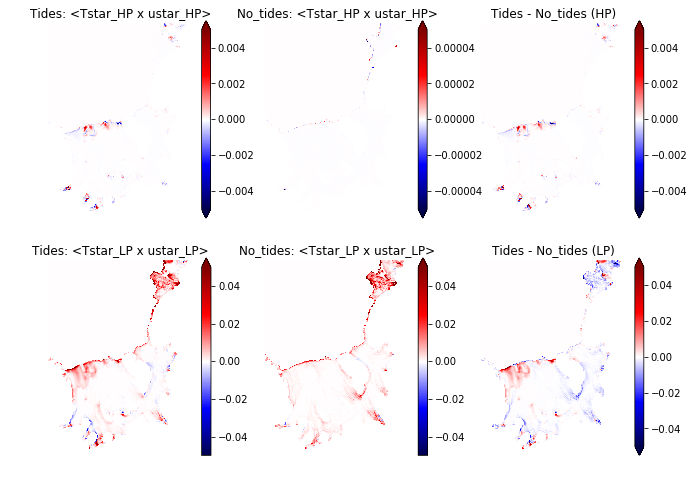

In [258]:
fig,axes = plt.subplots(ncols=3,nrows=2,figsize=(11,8))
ax1,ax2,ax3,ax4,ax5,ax6= axes.flatten()

mstarHP.plot(ax=ax1,vmin=-0.005,vmax=0.005,cmap='seismic')
ax1.set_title('Tides: <Tstar_HP x ustar_HP>')

mstarHP_nt.plot(ax=ax2,vmin=-0.00005,vmax=0.00005,cmap='seismic')
ax2.set_title('No_tides: <Tstar_HP x ustar_HP>')

(mstarHP-mstarHP_nt).plot(ax=ax3,vmin=-0.005,vmax=0.005,cmap='seismic')
ax3.set_title('Tides - No_tides (HP)')

mstarLP.plot(ax=ax4,vmin=-0.05,vmax=0.05,cmap='seismic')
ax4.set_title('Tides: <Tstar_LP x ustar_LP>')

mstarLP_nt.plot(ax=ax5,vmin=-0.05,vmax=0.05,cmap='seismic')
ax5.set_title('No_tides: <Tstar_LP x ustar_LP>')

(mstarLP-mstarLP_nt).plot(ax=ax6,vmin=-0.05,vmax=0.05,cmap='seismic')
ax6.set_title('Tides - No_tides (LP)')

for ax in axes.flatten():
    ax.set_aspect('equal')
    ax.axis('off')

#plt.tight_layout()
plt.show()

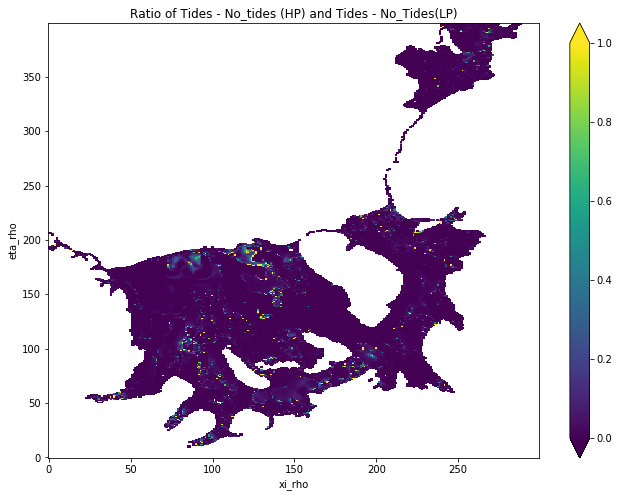

In [257]:
fig,ax = plt.subplots(figsize=(11,8))

((mstarHP-mstarHP_nt)/(mstarLP-mstarLP_nt)).plot(ax=ax,vmin=0,vmax=1)
ax.set_title('Ratio of Tides - No_tides (HP) and Tides - No_Tides(LP)')
plt.show()

## pan-Antarctic

In [83]:
fs = xr.open_dataset(os.path.join(int_dir,'filtered_star.nc'))
fsNt = xr.open_dataset(os.path.join(int_dir,'filtered_star_nt.nc'))
mask = ((grd.mask_rho==1) & (mask_shelf['Total Antarctica']==1))

In [84]:
from dask.distributed import Client
C = Client()
chunks = {'xi_rho':75,'eta_rho':75}

fs = fs.chunk(chunks)
fsNt = fsNt.chunk(chunks)

In [85]:
mstar_HPHP = (fs.ustarHP*fs.TstarHP).where(mask).mean('ocean_time')
mstar_LPLP = (fs.ustarLP*fs.TstarLP).where(mask).mean('ocean_time')
mstar_HPLP = (fs.ustarHP*fs.TstarLP).where(mask).mean('ocean_time')
mstar_LPHP = (fs.ustarLP*fs.TstarHP).where(mask).mean('ocean_time')

mstar_HPHP_nt = (fsNt.ustarHP*fsNt.TstarHP).where(mask).mean('ocean_time')
mstar_LPLP_nt = (fsNt.ustarLP*fsNt.TstarLP).where(mask).mean('ocean_time')
mstar_HPLP_nt = (fsNt.ustarHP*fsNt.TstarLP).where(mask).mean('ocean_time')
mstar_LPHP_nt = (fsNt.ustarLP*fsNt.TstarHP).where(mask).mean('ocean_time')

dHPHP = (mstar_HPHP - mstar_HPHP_nt).load(); print('ping')
dLPLP = (mstar_LPLP - mstar_LPLP_nt).load(); print('ping')
dHPLP = (mstar_HPLP - mstar_HPLP_nt).load(); print('ping')
dLPHP = (mstar_LPHP - mstar_LPHP_nt).load(); print('ping')
dm = (dHPHP+dLPLP+dHPLP+dLPHP).load()

distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://127.0.0.1:53495 remote=tcp://127.0.0.1:54328>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://127.0.0.1:53496 remote=tcp://127.0.0.1:54328>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://127.0.0.1:53497 remote=tcp://127.0.0.1:54328>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://127.0.0.1:53513 remote=tcp://127.0.0.1:54328>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://127.0.0.1:53542 remote=tcp://127.0.0.1:54328>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://127.0.0.1:53608 remote=tcp://127.0.0.1:54328>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://127.0.0.1:33328 remote=tcp://127.0.0.1:56531>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://127.0.0.1:53702 remote=tcp://127.0.0.1:54328>
distributed.comm

ping


distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://127.0.0.1:53815 remote=tcp://127.0.0.1:54328>


ping
ping
ping


distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://127.0.0.1:40027 remote=tcp://127.0.0.1:49885>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://127.0.0.1:36622 remote=tcp://127.0.0.1:53223>


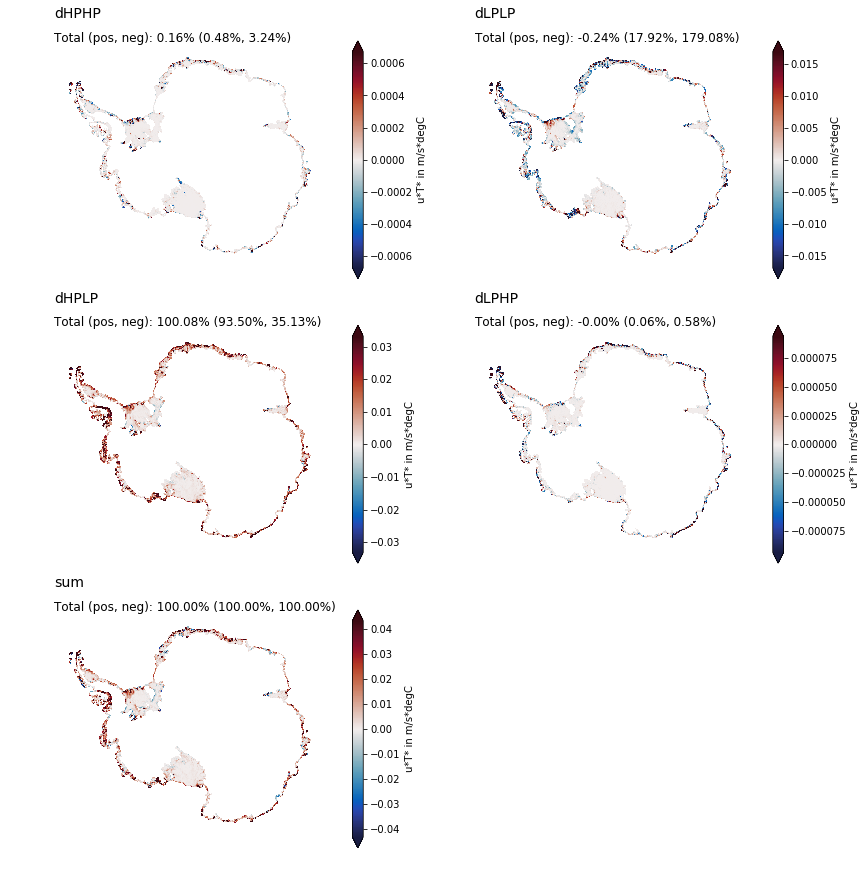

In [87]:
fig,axes = plt.subplots(ncols=2,nrows=3,figsize=(12,12))
ax1,ax2,ax3,ax4,ax5,ax6 = axes.flatten()

ax1 = plot_m(ax1,dHPHP, 'dHPHP')
ax2 = plot_m(ax2,dLPLP, 'dLPLP')
ax3 = plot_m(ax3,dHPLP, 'dHPLP')
ax4 = plot_m(ax4,dLPHP, 'dLPHP')
ax5 = plot_m(ax5,dm, 'sum')


for ax in axes.flatten():
    ax.set_aspect('equal')
    ax.axis('off')
plt.tight_layout()
plt.show()

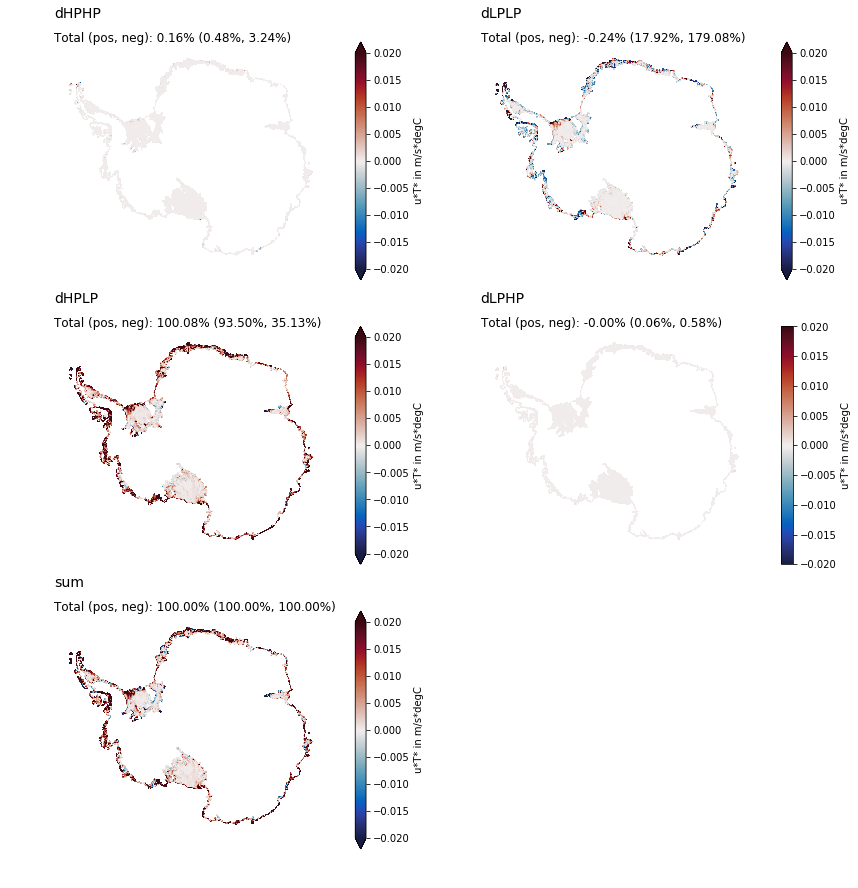

distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://127.0.0.1:36624 remote=tcp://127.0.0.1:53223>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://127.0.0.1:33520 remote=tcp://127.0.0.1:56531>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://127.0.0.1:40031 remote=tcp://127.0.0.1:49885>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://127.0.0.1:53900 remote=tcp://127.0.0.1:54328>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://127.0.0.1:36705 remote=tcp://127.0.0.1:53223>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://127.0.0.1:40112 remote=tcp://127.0.0.1:49885>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://127.0.0.1:33604 remote=tcp://127.0.0.1:56531>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://127.0.0.1:53936 remote=tcp://127.0.0.1:54328>
distributed.comm

In [88]:
fig,axes = plt.subplots(ncols=2,nrows=3,figsize=(12,12))
ax1,ax2,ax3,ax4,ax5,ax6 = axes.flatten()

ax1 = plot_m(ax1,dHPHP, 'dHPHP',vmin = -0.02,vmax=0.02)
ax2 = plot_m(ax2,dLPLP, 'dLPLP',vmin = -0.02,vmax=0.02)
ax3 = plot_m(ax3,dHPLP, 'dHPLP',vmin = -0.02,vmax=0.02)
ax4 = plot_m(ax4,dLPHP, 'dLPHP',vmin = -0.02,vmax=0.02)
ax5 = plot_m(ax5,dm, 'sum',vmin = -0.02,vmax=0.02)


for ax in axes.flatten():
    ax.set_aspect('equal')
    ax.axis('off')
plt.tight_layout()
plt.show()

# other regions

In [23]:
sel1 = {'xi_rho':slice(714,1243),'eta_rho':slice(1408,1875)} #FRIS
sel2 = {'xi_rho':slice(1185,1726),'eta_rho':slice(652,1146)} #Ross
sel3 = {'xi_rho':slice(380,648),'eta_rho':slice(1114,1780)} #BSeas
sel4 = {'xi_rho':slice(655,924),'eta_rho':slice(720,1244)} #ASeas
sel5 = {'xi_rho':slice(2568,2665),'eta_rho':slice(637,867)} # Totten
sel6 = {'xi_rho':slice(2322,2652),'eta_rho':slice(1650,1781)} # Amery
sel7 = {'xi_rho':slice(1409,1595),'eta_rho':slice(2338,2496)} # Fimbul
sel8 = {'xi_rho':slice(295,534),'eta_rho':slice(1830,2030)} # LarsenC
sel9 = {'xi_rho':slice(390,650),'eta_rho':slice(1500,1775)} # GeorgeV
sel10 = {'xi_rho':slice(550,775),'eta_rho':slice(1000,1250)} # PI
sel11 = {'xi_rho':slice(2550,2750),'eta_rho':slice(650,860)} # Totten
sel12 = {'xi_rho':slice(2330,2640),'eta_rho':slice(1550,1850)} # Amery
sel13 = {'xi_rho':slice(425*5,455*5),'eta_rho':slice(45*5,75*5)} # Mertz
sel14 = {'xi_rho':slice(545*5,595*5),'eta_rho':slice(200*5,250*5)} # Shackleton

sels = {'FRIS':sel1,'Ross':sel2,'GeorgeV':sel9,'PI':sel10,'Totten':sel11,'Amery':sel12,'Fimbul':sel7,
        'LarsenC':sel8,'Mertz':sel13,'Shackleton':sel14}

In [24]:
#from dask.distributed import Client
#C = Client()

def plot_region(fs,fsNt,sel):
    
    for k,i in sel.items():
        sel[k] = slice(i.start//2,i.stop//2)
    
    fs = fs.isel(sel)
    fsNt = fs_nt.isel(sel)
    mask = ((grd.mask_rho==1) & (mask_shelf['Total Antarctica']==1)).isel(sel)
    chunks = {'xi_rho':75,'eta_rho':75}
    fs = fs.chunk(chunks)
    fsNt = fsNt.chunk(chunks)
    
    mstar_HPHP = (fs.ustarHP*fs.TstarHP).where(mask).mean('ocean_time')
    mstar_LPLP = (fs.ustarLP*fs.TstarLP).where(mask).mean('ocean_time')
    mstar_HPLP = (fs.ustarHP*fs.TstarLP).where(mask).mean('ocean_time')
    mstar_LPHP = (fs.ustarLP*fs.TstarHP).where(mask).mean('ocean_time')

    mstar_HPHP_nt = (fsNt.ustarHP*fsNt.TstarHP).where(mask).mean('ocean_time')
    mstar_LPLP_nt = (fsNt.ustarLP*fsNt.TstarLP).where(mask).mean('ocean_time')
    mstar_HPLP_nt = (fsNt.ustarHP*fsNt.TstarLP).where(mask).mean('ocean_time')
    mstar_LPHP_nt = (fsNt.ustarLP*fsNt.TstarHP).where(mask).mean('ocean_time')

    dHPHP = (mstar_HPHP - mstar_HPHP_nt).load(); print('ping')
    dLPLP = (mstar_LPLP - mstar_LPLP_nt).load(); print('ping')
    dHPLP = (mstar_HPLP - mstar_HPLP_nt).load(); print('ping')
    dLPHP = (mstar_LPHP - mstar_LPHP_nt).load(); print('ping')
    dm = (dHPHP+dLPLP+dHPLP+dLPHP).load()
    
    vmin=-dm.std()*2
    vmax=dm.std()*2
    
    fig,axes = plt.subplots(ncols=2,nrows=3,figsize=(12,12))
    ax1,ax2,ax3,ax4,ax5,ax6 = axes.flatten()

    ax1 = plot_m(ax1,dHPHP,dm, 'dHPHP',vmin=vmin,vmax=vmax)
    ax2 = plot_m(ax2,dLPLP,dm, 'dLPLP',vmin=vmin,vmax=vmax)
    ax3 = plot_m(ax3,dHPLP,dm, 'dHPLP',vmin=vmin,vmax=vmax)
    ax4 = plot_m(ax4,dLPHP,dm, 'dLPHP',vmin=vmin,vmax=vmax)
    ax5 = plot_m(ax5,dm,dm, 'sum',vmin=vmin,vmax=vmax)

    for ax in axes.flatten():
        ax.set_aspect('equal')
        ax.axis('off')
    plt.tight_layout()
    plt.show()

processing FRIS
ping
ping
ping
ping


ValueError: arguments without labels along dimension 'eta_rho' cannot be aligned because they have different dimension sizes: {233, 1325}

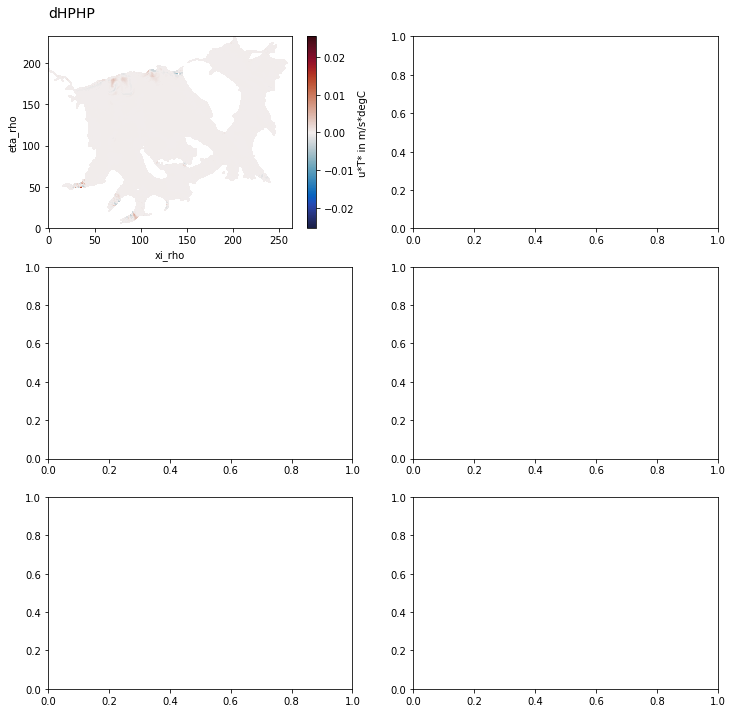

In [25]:
fs = xr.open_dataset(os.path.join(int_dir,'filtered_star.nc'))
fsNt = xr.open_dataset(os.path.join(int_dir,'filtered_star_nt.nc'))

from dask.distributed import Client

for k,sel in sels.items():
    print(f'processing {k}')
    plot_region(fs,fsNt,sel)

In [20]:
%debug

> <ipython-input-15-a248fdc15fe2>(7)plot_m()
      4     else:
      5         da.plot(ax=ax,vmin=vmin,vmax=vmax,cmap=ocm.balance,cbar_kwargs={'label': 'u*T* in m/s*degC'})
      6     ax = make_text(ax,text)
----> 7     ax = show_perc(ax,da,dm,grd)
      8     return ax

ipdb> dm
*** NameError: name 'dm' is not defined
ipdb> q


## old

In [ ]:
s2a=3600*24*365.25
mask = (grd.mask_rho ==1) &(grd.zice<0)
m_mean = tides.m.mean('ocean_time').where(mask)*s2a
m_std = tides.m.std('ocean_time').where(mask)*s2a

distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting

In [27]:
fs = fs.chunk(chunks)
mstar_mean = ((fs.TstarHP + fs.TstarLP) * (fs.ustarHP + fs.ustarLP)).where(mask).mean('ocean_time').load()
print('ping')
mstar_std = ((fs.TstarHP + fs.TstarLP) * (fs.ustarHP + fs.ustarLP)).where(mask).std('ocean_time').load()

ping


In [91]:
def zoom(da):
    return da.dropna('eta_rho','all').dropna('xi_rho','all')
def make_text(ax,text):
    ax.text(0.5, 0.5, text, horizontalalignment='center',verticalalignment='center',
                   transform=ax.transAxes,size=14)
    return ax

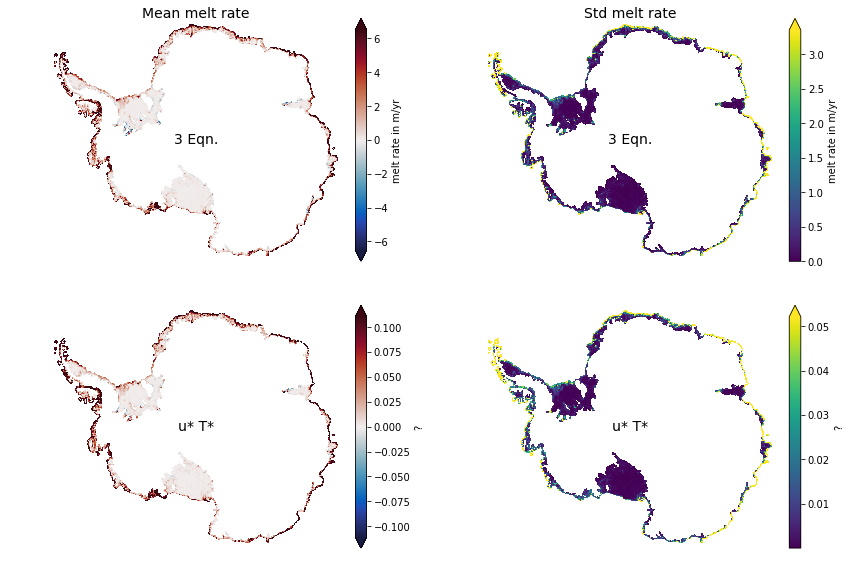

In [48]:
fig,axes = plt.subplots(2,2,figsize=(12,8.27))
ax1,ax2,ax3,ax4 = axes.flatten()
zoom(m_mean).plot(ax=ax1,vmin=-m_mean.std()*2,vmax=m_mean.std()*2,
                  cmap=ocm.balance,cbar_kwargs={'label': 'melt rate in m/yr'})
zoom(m_std).plot(ax=ax2,vmax=m_std.std()*2,cbar_kwargs={'label': 'melt rate in m/yr'})

zoom(mstar_mean).plot(ax=ax3,vmin=-mstar_mean.std()*2,vmax=mstar_mean.std()*2,
                      cmap=ocm.balance,cbar_kwargs={'label': '?'})
zoom(mstar_std).plot(ax=ax4,vmax=mstar_std.std()*2,cbar_kwargs={'label': '?'})

ax1.set_title('Mean melt rate',size=14)
ax2.set_title('Std melt rate',size=14)

ax1 = text(ax1,'3 Eqn.')
ax3 = text(ax3,'u* T*')
ax2 = text(ax2,'3 Eqn.')
ax4 = text(ax4,'u* T*')

for ax in axes.flatten():
    ax.set_aspect('equal')
    ax.axis('off')
plt.tight_layout()
plt.show()

In [89]:
def plot_m(ax,da,text):
    da.plot(ax=ax,vmin=-da.std()*2,vmax=da.std()*2,cmap=ocm.balance,cbar_kwargs={'label': 'u*T* in ?'})
    ax = make_text(ax,text)
    return ax


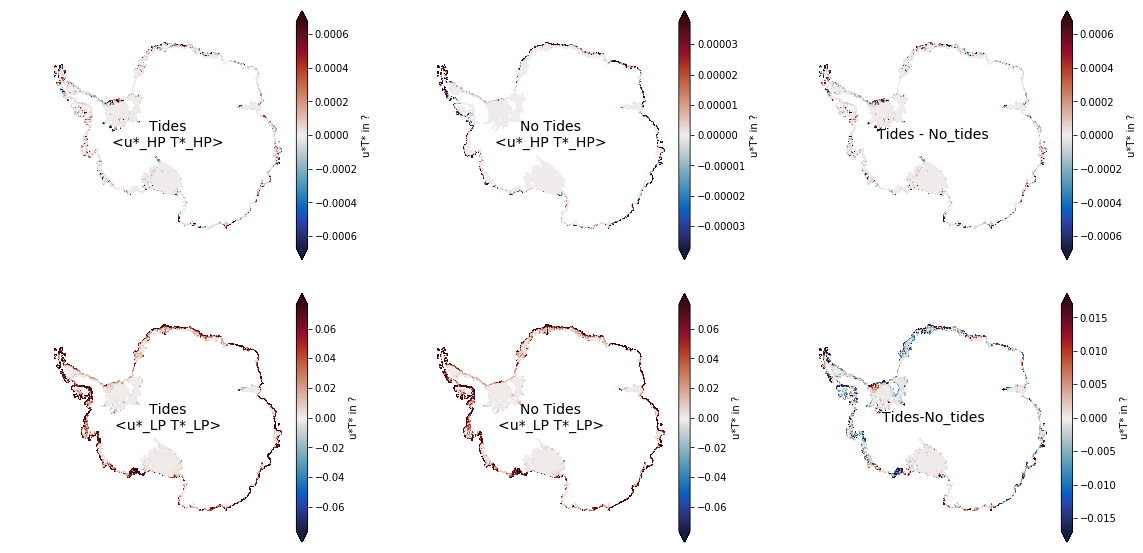

In [79]:
fig,axes = plt.subplots(ncols=3,nrows=2,figsize=(16,8))
ax1,ax2,ax3,ax4,ax5,ax6 = axes.flatten()

ax1 = plot_m(ax1,mstar_HP,'Tides\n<u*_HP T*_HP>')
ax2 = plot_m(ax2,mstar_HP_nt,'No Tides\n<u*_HP T*_HP>')
ax3 = plot_m(ax3,mstar_HP-mstar_HP_nt,'Tides - No_tides')
ax4 = plot_m(ax4,mstar_LP,'Tides\n<u*_LP T*_LP>')
ax5 = plot_m(ax5,mstar_LP_nt,'No Tides\n<u*_LP T*_LP>')
ax6 = plot_m(ax6,mstar_LP-mstar_LP_nt,'Tides-No_tides')

for ax in axes.flatten():
    ax.set_aspect('equal')
    ax.axis('off')
plt.tight_layout()
plt.show()

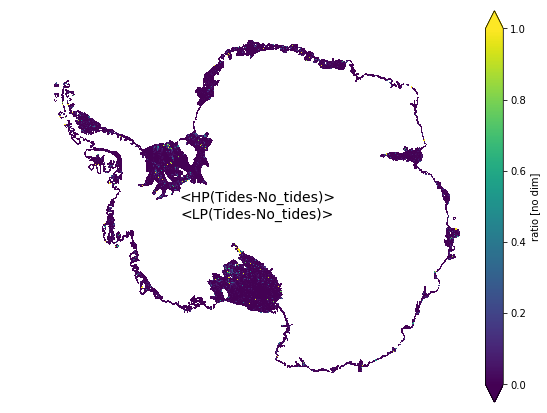

In [96]:
fig,ax = plt.subplots(figsize=(8,6))
#ax = plot_m(ax,(mstar_HP-mstar_HP_nt)/(mstar_LP-mstar_LP_nt),'HP(Tides-No_tides)\nLP(Tides-No_tides)>')
((mstar_HP-mstar_HP_nt)/(mstar_LP-mstar_LP_nt)).plot(ax=ax,vmin=0,vmax=1,cmap='viridis',cbar_kwargs={'label': 'ratio [no dim]'})
ax.set_aspect('equal')
ax = make_text(ax,'<HP(Tides-No_tides)>\n<LP(Tides-No_tides)>')
ax.axis('off')
plt.tight_layout()
plt.show()

In [107]:
mstar = zoom(((fs.TstarHP + fs.TstarLP) * (fs.ustarHP + fs.ustarLP)).where(mask)).mean('ocean_time').load()
mstar_u = zoom(((fs.TstarHP + fs.TstarLP) * ( fs.ustarLP)).where(mask)).mean('ocean_time').load()
mstar_T = zoom(((fs.TstarLP) * (fs.ustarHP + fs.ustarLP)).where(mask)).mean('ocean_time').load()

fig,axes = plt.subplots(2,2,figsize=(12,8.27))
ax1,ax2,ax3,ax4 = axes.flatten()

ax1 = plot_m(ax1,mstar,'mstar:\n<(u*_HP+u*_LP)x(T*_HP+T*_LP)>')
ax2 = plot_m(ax2,mstar_u-mstar,'mstar_u*:\n<(u*_LP)x(T*_HP+T*_LP)> - mstar')
ax3 = plot_m(ax3,mstar_T-mstar,'mstar_T*:\n<(u*_HP+u*_LP)x(T*_LP)> - mstar')
(np.abs(mstar_u-mstar)/np.abs(mstar_T-mstar)).plot(ax=ax4,vmin=0,vmax=10,cmap='viridis',cbar_kwargs={'label': 'u*T* in ?'})
ax4 = make_text(ax4,'|mstar_u*|/|mstar_T*|')

for ax in axes.flatten():
    ax.set_aspect('equal')
    ax.axis('off')
plt.tight_layout()
plt.show()

In [102]:
mstar = zoom(((fs.TstarHP + fs.TstarLP) * (fs.ustarHP + fs.ustarLP)).where(mask)).mean('ocean_time').load()
mstar_u = zoom(((fs.TstarHP + fs.TstarLP) * ( fs.ustarHP)).where(mask)).mean('ocean_time').load()
mstar_T = zoom(((fs.TstarHP) * (fs.ustarHP + fs.ustarLP)).where(mask)).mean('ocean_time').load()

fig,axes = plt.subplots(2,2,figsize=(12,8.27))
ax1,ax2,ax3,ax4 = axes.flatten()

ax1 = plot_m(ax1,mstar,'mstar:\n<(u*_HP+u*_LP)x(T*_HP+T*_LP)>')
ax2 = plot_m(ax2,mstar_u-mstar,'mstar_u*:\n<(u*_HP)x(T*_HP+T*_LP)> - mstar')
ax3 = plot_m(ax3,mstar_T-mstar,'mstar_T*:\n<(u*_HP+u*_LP)x(T*_HP)> - mstar')
(np.abs(mstar_u-mstar)/np.abs(mstar_T-mstar)).plot(ax=ax4,vmin=0,vmax=1,cmap='viridis',cbar_kwargs={'label': 'u*T* in ?'})
ax4 = make_text(ax4,'|mstar_u*|/|mstar_T*|')

for ax in axes.flatten():
    ax.set_aspect('equal')
    ax.axis('off')
plt.tight_layout()
plt.show()

# u* T* decomposition

In [186]:
file_path = os.path.join(raw_dir,'waom4_hr','ocean_avg_0010.nc')
tides = xr.open_dataset(file_path)#,chunks={'xi_rho':75,'eta_rho':75})
file_path = os.path.join(raw_dir,'waom4_hr_nt','ocean_avg_0010.nc')
no_tides = xr.open_dataset(file_path)#,chunks={'xi_rho':75,'eta_rho':75})
grid_path = os.path.join(int_dir,'grd4_dV.nc')
grd = xr.open_dataset(grid_path)

rho_sel = {'xi_rho' : slice(350,650),'eta_rho' : slice(700,950)}
fris = tides.isel(rho_sel)
frisNt = no_tides.isel(rho_sel)
mask = ((grd.mask_rho==1) & (mask_shelf['Total Antarctica']==1)).isel(rho_sel)

fris = fris.chunk(chunks)
frisNt = frisNt.chunk(chunks)

In [187]:
frisNt.ustar

<xarray.DataArray 'ustar' (ocean_time: 720, eta_rho: 250, xi_rho: 300)>
dask.array<shape=(720, 250, 300), dtype=float32, chunksize=(720, 75, 75)>
Coordinates:
    x_rho       (eta_rho, xi_rho) float64 dask.array<shape=(250, 300), chunksize=(75, 75)>
    y_rho       (eta_rho, xi_rho) float64 dask.array<shape=(250, 300), chunksize=(75, 75)>
  * ocean_time  (ocean_time) datetime64[ns] 2015-12-30T00:30:00 ...
Dimensions without coordinates: eta_rho, xi_rho
Attributes:
    long_name:  time-averaged friction velocity at ice base
    units:      meter second-1
    time:       ocean_time
    field:      friction_velocity, scalar, series

In [188]:
udt = (frisNt.ustar*(fris.Tstar-frisNt.Tstar)).mean('ocean_time').load()
dudt = ((fris.ustar-frisNt.ustar)*(fris.Tstar-frisNt.Tstar)).mean('ocean_time').load()
dut = ((fris.ustar-frisNt.ustar)*frisNt.Tstar).mean('ocean_time').load()

In [190]:
udt

<xarray.DataArray (eta_rho: 250, xi_rho: 300)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [ 0.,  0.,  0., ..., nan, nan, nan],
       [ 0.,  0.,  0., ..., nan, nan, nan],
       [ 0.,  0.,  0., ..., nan, nan, nan]], dtype=float32)
Coordinates:
    x_rho    (eta_rho, xi_rho) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    y_rho    (eta_rho, xi_rho) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
Dimensions without coordinates: eta_rho, xi_rho

In [189]:
fig,axes = plt.subplots(2,2,figsize=(12,8.27))
ax1,ax2,ax3 = axes.flatten()

ax1 = plot_m(ax1,udt,'u dt')
ax2 = plot_m(ax2,dudt,'du dt')
ax3 = plot_m(ax3,dut,'du t')

for ax in axes.flatten():
    ax.set_aspect('equal')
    ax.axis('off')
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>

ValueError: too many values to unpack (expected 3)